# STA326 Assignment 2

In [196]:
import pandas as pd
import numpy as np

import folium
from h3 import h3

from pyecharts import options as opts
from pyecharts.charts import Bar,Grid

import matplotlib.pyplot as plt

In [197]:
df_offer = pd.read_csv("./datasets/data_offers.csv")
df_order = pd.read_csv("./datasets/data_orders.csv")

In [198]:
df = df_order.copy()
df['hour'] = df['order_datetime'].apply(lambda x: int(x[0:2]))
df.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,hour
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0,18
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,20
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0,12
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0,13
4,21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN,21


In [4]:
df.count()

order_datetime                   10716
origin_longitude                 10716
origin_latitude                  10716
m_order_eta                       2814
order_gk                         10716
order_status_key                 10716
is_driver_assigned_key           10716
cancellations_time_in_seconds     7307
hour                             10716
dtype: int64

## Task 1

In [4]:
df1 = df.groupby(['is_driver_assigned_key','order_status_key'])['order_gk'].count().reset_index()
df1

,is_driver_assigned_key,order_status_key,order_gk
0,0,4,4496
1,0,9,3406
2,1,4,2811
3,1,9,3


In [10]:
f1_1
f1_2[0]+1

3407

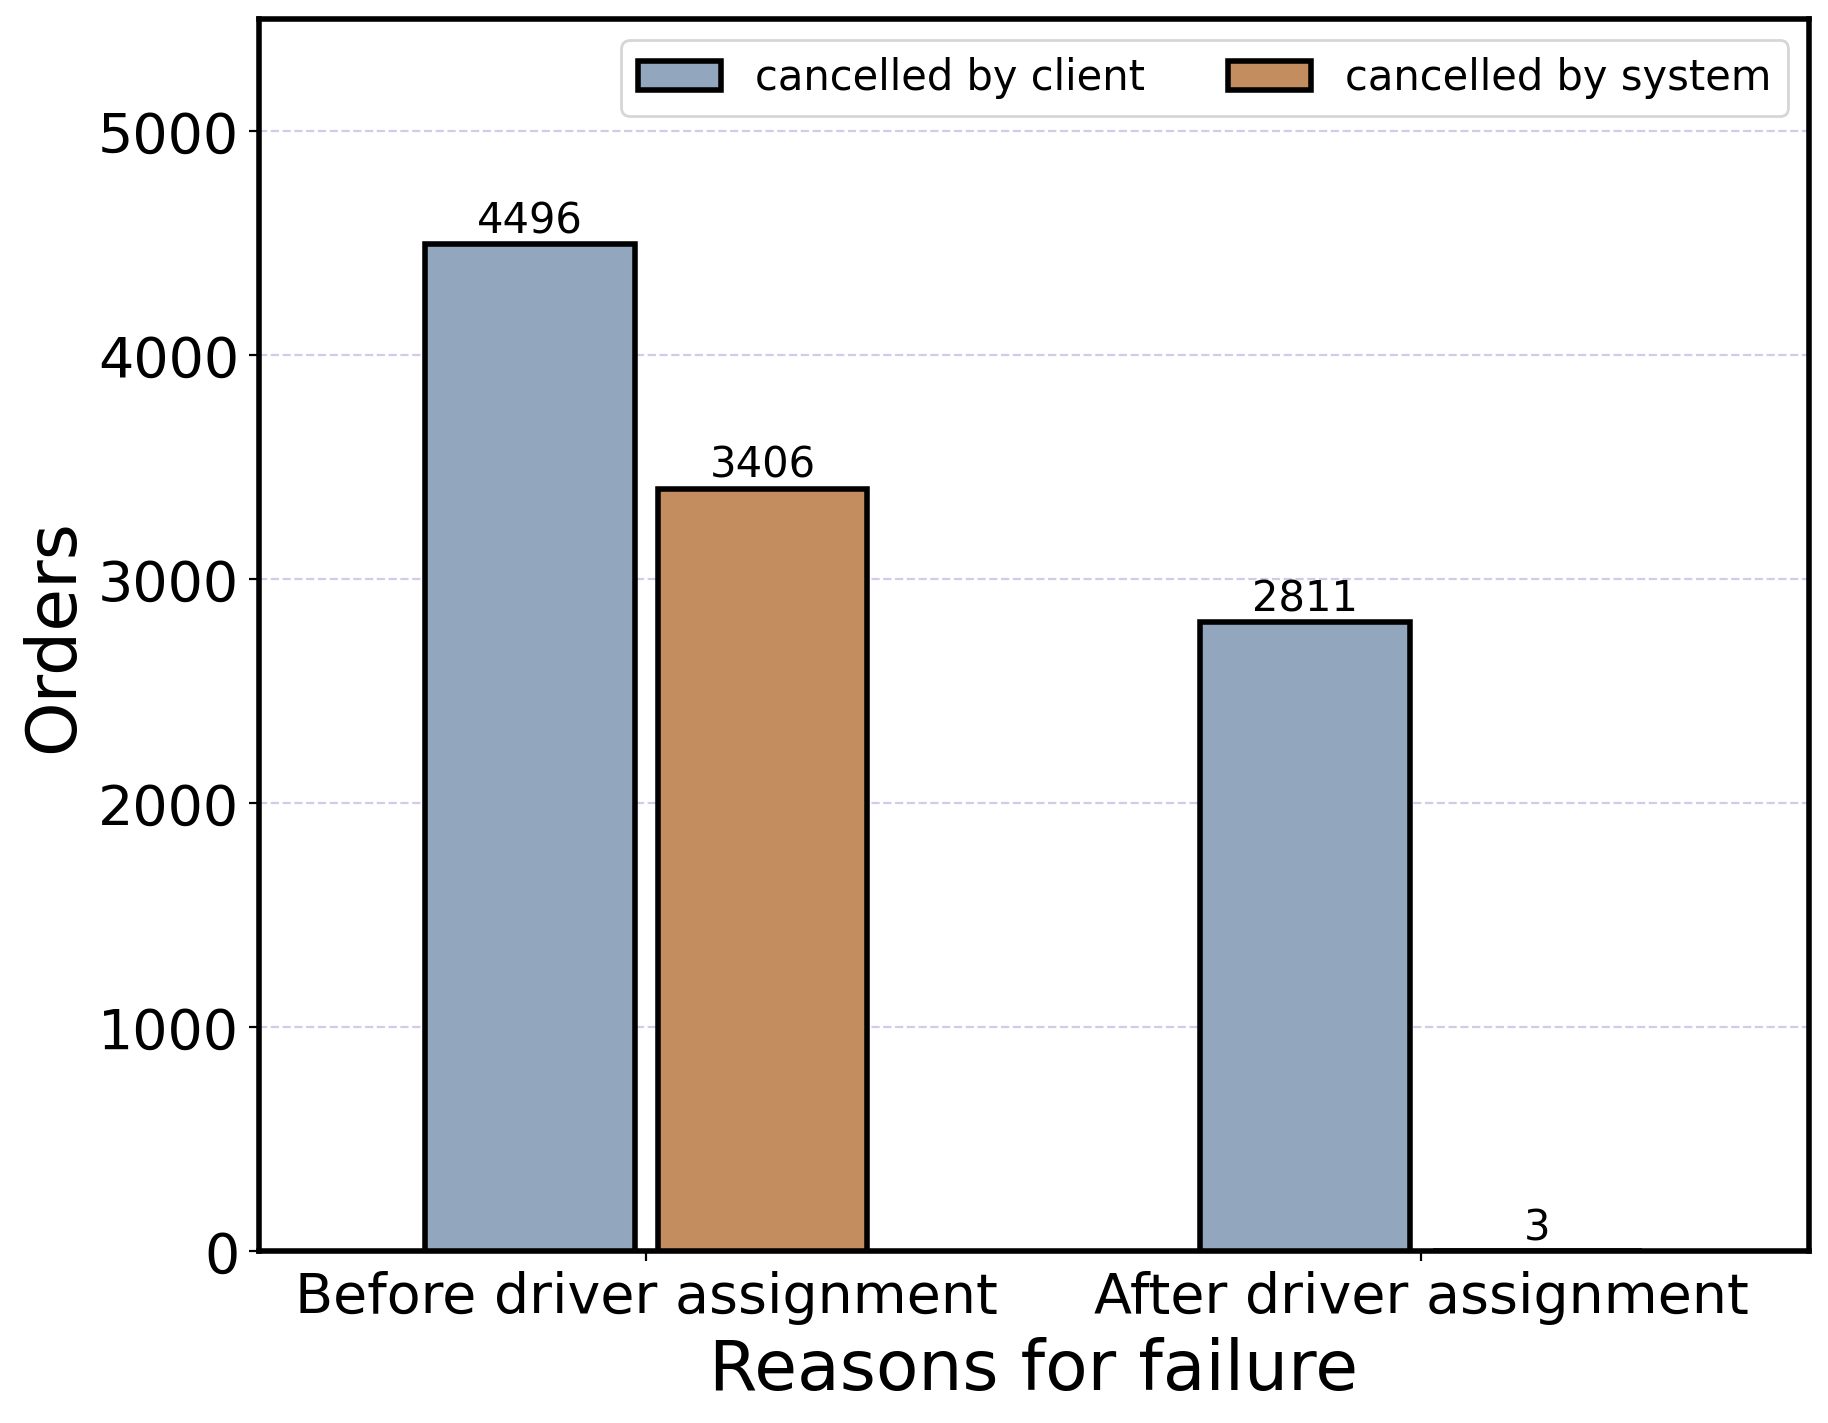

In [21]:

f1_1 = df1[df1['order_status_key']==4]['order_gk'].to_list()
f1_2 = df1[df1['order_status_key']==9]['order_gk'].to_list()

x = ['Before driver assignment','After driver assignment']
x_len = np.arange(len(x))
total_width, n = 0.6, 2
width = 0.3
xticks = x_len - (total_width - width) / 2
plt.figure(figsize=(10, 8), dpi=200)

ax = plt.axes()
plt.grid(axis="y", c='#d2c9eb', linestyle = '--',zorder=0)
plt.bar(xticks, f1_1, width=0.9*width, label="cancelled by client", color="#92a6be",edgecolor='black',linewidth = 2,  zorder=10)
plt.bar(xticks + width, f1_2, width=0.9*width, label="cancelled by system", color="#c48d60",edgecolor='black',linewidth = 2, zorder=10)

plt.text(xticks[0], f1_1[0] + 50, f1_1[0], ha='center', fontsize=15,  zorder=10)
plt.text(xticks[1], f1_1[1] + 50, f1_1[1], ha='center', fontsize=15,  zorder=10)

plt.text(xticks[0] + width, f1_2[0] + 50, f1_2[0], ha='center', fontsize=15,  zorder=10)
plt.text(xticks[1] + width, f1_2[1] + 50, f1_2[1], ha='center', fontsize=15,  zorder=10)

plt.legend(prop={'size': 15}, ncol = 2)
x_len = np.array([0,1])

plt.xticks(x_len, x,fontsize = 20)
plt.xlim(xmin=-0.5,xmax=1.5)
plt.yticks(fontsize = 20)
plt.ylim(ymax=5500)
plt.xlabel("Reasons for failure", fontsize=25)
plt.ylabel("Orders", fontsize=25)

ax.spines['bottom'].set_linewidth(2)
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_linewidth(2)
ax.spines['top'].set_color('black')
ax.spines['right'].set_linewidth(2)
ax.spines['right'].set_color('black')
ax.spines['left'].set_linewidth(2)
ax.spines['left'].set_color('black')

plt.show()

In [64]:
from pyecharts.globals import CurrentConfig, NotebookType
CurrentConfig.NOTEBOOK_TYPE = NotebookType.JUPYTER_LAB

%config InlineBackend.figure_format = 'svg'   
%matplotlib inline
# CurrentConfig.ONLINE_HOST='https://assets.pyecharts.org/assets/'

bar1 = (
    Bar()
    .add_xaxis(['Before driver assignment','After driver assignment'])
    .add_yaxis("Cancelled by client", df1[df1['order_status_key']==4]['order_gk'].to_list(),
               color='#92a6be',
               itemstyle_opts=opts.ItemStyleOpts(border_color="black"),
               category_gap="40%")
    .add_yaxis("Cancelled by system", df1[df1['order_status_key']==9]['order_gk'].to_list(), 
               color='#c48d60',
               itemstyle_opts=opts.ItemStyleOpts(border_color="black"),
               category_gap="40%")
    .set_series_opts(label_opts=opts.LabelOpts(position="top",font_size=20),itemstyle_opts=opts.ItemStyleOpts(border_color="black"))
    .set_global_opts(
        title_opts=opts.TitleOpts(
            title=f"The distribution of orders according to reasons for failure and\norder rejection",
            title_textstyle_opts=opts.TextStyleOpts(font_size=25),
        ),
        yaxis_opts=opts.AxisOpts(
            name="Orders",
            name_location='center',
            name_gap=65,
            axislabel_opts=opts.LabelOpts(color='black',formatter="{value}",font_size=20),
            name_textstyle_opts=opts.TextStyleOpts(color='black',font_size=25)
        ),
        xaxis_opts=opts.AxisOpts(
            name="Reasons for failure",
            name_location='center',
            name_gap=35,
            axislabel_opts=opts.LabelOpts(color='black',formatter="{value}",font_size=20),
            name_textstyle_opts=opts.TextStyleOpts(color='black',font_size=25),
        ),
        legend_opts=opts.LegendOpts(
            pos_right='15.5%',pos_top='15.5%',item_width=45,item_height=20,
            legend_icon='rect',
            orient='vertical',
            padding=7,
#             item_gap=25,
            border_color='#ccc',
            border_width=1,
            textstyle_opts=opts.TextStyleOpts(color='black',font_size=20)
        ),
    )
)

grid1 = Grid(init_opts=opts.InitOpts(width="900px", height="650px"))
grid1.add(bar1, opts.GridOpts(is_show=True,border_color='black', border_width=2,
                              pos_left="15%",pos_right='15%',pos_top='15%',pos_bottom='15%'))
grid1.render("./task1.html")
# bar1.load_javascript()
# bar1.render_notebook()

'/data/lab/STA326_Assignment2/task1.html'

## Task 2

Plot the distribution of failed orders by hours.

In [50]:
df2 = df.groupby('hour').agg({'order_gk':'count'}).reset_index()
df2.head()

,hour,order_gk
0,0,683
1,1,471
2,2,555
3,3,513
4,4,152


In [78]:

bar2 = (
    Bar()
    .add_xaxis(df2['hour'].to_list())
    .add_yaxis("Failed orders",df2['order_gk'].to_list(), category_gap=0.5, color='#5DA3AF')
    .set_series_opts(label_opts=opts.LabelOpts(position="top",font_size=16),)
    .set_global_opts( 
        title_opts=opts.TitleOpts(
            title="The distribution of failed orders by hours",
            padding=3,
            title_textstyle_opts=opts.TextStyleOpts(font_size=28),
            item_gap = 10
        ),
        yaxis_opts=opts.AxisOpts(
            name="Failed orders",
            name_location='center',
            name_gap=60,
            axislabel_opts=opts.LabelOpts(color='black',formatter="{value}",font_size=20),
            name_textstyle_opts=opts.TextStyleOpts(color='black',font_size=25)
        ),
        xaxis_opts=opts.AxisOpts(
            name="Hours",
            name_location='center',
            name_gap=40,
            axislabel_opts=opts.LabelOpts(color='black',formatter='{value}h',font_size=20),
            name_textstyle_opts=opts.TextStyleOpts(color='black',font_size=25),
            axistick_opts=opts.AxisTickOpts(is_align_with_label=True)
        ),
        legend_opts=opts.LegendOpts(is_show=False),
    )
)

grid2 = Grid(init_opts=opts.InitOpts(width="1000px", height="750px"))
grid2.add(bar2, opts.GridOpts(
#     is_show=True, border_width=2,border_color='black'
    pos_left="15%",pos_right='15%',pos_top='15%',pos_bottom='15%')
)
grid2.render("./task2.html")


'/data/lab/STA326_Assignment2/task2.html'

Plot the distribution of failed orders with and without driver

In [296]:
df21 = df.groupby(['is_driver_assigned_key','hour']).agg({'order_gk':'count'}).reset_index()

driver_list = [round(x/y,2) for x,y in zip(df21[df21['is_driver_assigned_key']==0]['order_gk'].tolist(),
                                  df21[df21['is_driver_assigned_key']==1]['order_gk'].tolist())]

In [300]:
bar21 = (
    Bar()
    .add_xaxis(df3[df3['is_driver_assigned_key']==0]['hour'].to_list())
    .add_yaxis("Without driver / with driver", driver_list, 
            color='#86c0cb',)
    .set_series_opts(label_opts=opts.LabelOpts(position="top",font_size=14),)
    .set_global_opts( 
        title_opts=opts.TitleOpts(
            title="The average time to cancellation with and without driver",
            padding=3,
            title_textstyle_opts=opts.TextStyleOpts(font_size=28),
            item_gap = 10
        ),
        yaxis_opts=opts.AxisOpts(
            name="Proportion",
            name_location='center',
            name_gap=35,
            axislabel_opts=opts.LabelOpts(color='black',formatter="{value}s",font_size=20),
            name_textstyle_opts=opts.TextStyleOpts(color='black',font_size=25)
        ),
        xaxis_opts=opts.AxisOpts(
            name="Hours",
            name_location='center',
            name_gap=35,
            axislabel_opts=opts.LabelOpts(color='black',formatter="{value}h",font_size=18.5),
            name_textstyle_opts=opts.TextStyleOpts(color='black',font_size=25),
        ),
        legend_opts=opts.LegendOpts(
            pos_right='15.5%',pos_top='15.5%',item_width=45,item_height=20,
            legend_icon='rect',
            orient='vertical',
            padding=7,
            border_color='#ccc',
            border_width=1,
            textstyle_opts=opts.TextStyleOpts(color='black',font_size=20)
        ),
    )
)

grid21 = Grid(init_opts=opts.InitOpts(width="1000px", height="750px"))
grid21.add(bar21, opts.GridOpts(
    pos_left="15%",pos_right='15%',pos_top='15%',pos_bottom='15%')
)
grid21.render("./task2_driver.html")

'/data/lab/STA326_Assignment2/task2_driver.html'

Plot the distribution of failed orders for the reasons for order rejection

In [295]:
df22 = df.groupby(['order_status_key','hour']).agg({'order_gk':'count'}).reset_index()
# df22.head()

status_list = [round(x/y,2) for x,y in zip(df22[df22['order_status_key']==4]['order_gk'].tolist(),
                                  df22[df22['order_status_key']==9]['order_gk'].tolist())]

In [301]:
bar22 = (
    Bar()
    .add_xaxis(df3[df3['is_driver_assigned_key']==0]['hour'].to_list())
    .add_yaxis("Cancelled by client / by system", status_list, 
            color='#86c0cb',)
    .set_series_opts(label_opts=opts.LabelOpts(position="top",font_size=14),)
    .set_global_opts( 
        title_opts=opts.TitleOpts(
            title="The average time to cancellation with and without driver",
            padding=3,
            title_textstyle_opts=opts.TextStyleOpts(font_size=28),
            item_gap = 10
        ),
        yaxis_opts=opts.AxisOpts(
            name="Proportion",
            name_location='center',
            name_gap=35,
            axislabel_opts=opts.LabelOpts(color='black',formatter="{value}",font_size=20),
            name_textstyle_opts=opts.TextStyleOpts(color='black',font_size=25)
        ),
        xaxis_opts=opts.AxisOpts(
            name="Hours",
            name_location='center',
            name_gap=35,
            axislabel_opts=opts.LabelOpts(color='black',formatter="{value}h",font_size=20),
            name_textstyle_opts=opts.TextStyleOpts(color='black',font_size=25),
            axistick_opts=opts.AxisTickOpts(is_align_with_label=True)
        ),
        legend_opts=opts.LegendOpts(
            is_show=False
        ),
    )
)

grid22 = Grid(init_opts=opts.InitOpts(width="1000px", height="750px"))
grid22.add(bar22, opts.GridOpts(
    pos_left="15%",pos_right='15%',pos_top='15%',pos_bottom='15%')
)
grid22.render("./task2_status.html")

'/data/lab/STA326_Assignment2/task2_status.html'

## Task 3

In [223]:
# mean = df[df['is_driver_assigned_key']==0]['cancellations_time_in_seconds'].mean()
# std_dev = df[df['is_driver_assigned_key']==0]['cancellations_time_in_seconds'].std()

# threshold = 3 * std_dev

# outliers = df[df['is_driver_assigned_key']==0][(df[df['is_driver_assigned_key']==0]['cancellations_time_in_seconds'] - mean).abs() > threshold]

# print("异常值数量:", outliers.shape[0])
# print("异常值:", outliers)


In [230]:
df3 = df[df['cancellations_time_in_seconds']<=1800].groupby(['is_driver_assigned_key','hour'])['cancellations_time_in_seconds'].agg(lambda x: round(np.mean(x),0)).reset_index()

In [257]:

bar3 = (
    Bar()
    .add_xaxis(df3[df3['is_driver_assigned_key']==0]['hour'].to_list())
    .add_yaxis("Without driver", df3[df3['is_driver_assigned_key']==0]['cancellations_time_in_seconds'].to_list(), 
            color='#86c0cb',)
    .add_yaxis("With driver", df3[df3['is_driver_assigned_key']==1]['cancellations_time_in_seconds'].to_list(), 
            color='#108994',)
    .set_series_opts(label_opts=opts.LabelOpts(position="top",font_size=14),)
    .set_global_opts( 
        title_opts=opts.TitleOpts(
            title="The average time to cancellation with and without driver",
            padding=3,
            title_textstyle_opts=opts.TextStyleOpts(font_size=28),
            item_gap = 10
        ),
        yaxis_opts=opts.AxisOpts(
            name="Average cancellation time",
            name_location='center',
            name_gap=65,
            axislabel_opts=opts.LabelOpts(color='black',formatter="{value}s",font_size=20),
            name_textstyle_opts=opts.TextStyleOpts(color='black',font_size=25)
        ),
        xaxis_opts=opts.AxisOpts(
            name="Hours",
            name_location='center',
            name_gap=35,
            axislabel_opts=opts.LabelOpts(color='black',formatter="{value}h",font_size=18.5),
            name_textstyle_opts=opts.TextStyleOpts(color='black',font_size=25),
        ),
        legend_opts=opts.LegendOpts(
            pos_right='15.5%',pos_top='15.5%',item_width=45,item_height=20,
            legend_icon='rect',
            orient='vertical',
            padding=7,
            border_color='#ccc',
            border_width=1,
            textstyle_opts=opts.TextStyleOpts(color='black',font_size=20)
        ),
    )
)

grid3 = Grid(init_opts=opts.InitOpts(width="1500px", height="900px"))
grid3.add(bar3, opts.GridOpts(
    pos_left="15%",pos_right='15%',pos_top='15%',pos_bottom='15%')
)
grid3.render("./task3.html")

'/data/lab/STA326_Assignment2/task3.html'

## Task 4

In [79]:
df4 = df.groupby('hour')['m_order_eta'].agg(lambda x: round(np.mean(x),0)).reset_index()

df4.head()

,hour,m_order_eta
0,0,358.0
1,1,325.0
2,2,391.0
3,3,388.0
4,4,300.0


In [87]:
from pyecharts import options as opts
from pyecharts.charts import Bar
# from pyecharts.render import make_snapshot
# from snapshot_selenium import snapshot as driver
from pyecharts.globals import CurrentConfig, NotebookType
CurrentConfig.NOTEBOOK_TYPE = NotebookType.JUPYTER_NOTEBOOK

bar4 = (
    Bar()
    .add_xaxis(df4['hour'].to_list())
    .add_yaxis("Average ETA", df4['m_order_eta'].to_list(), category_gap=0.5, color='#5DA3AF',)
    .set_series_opts(label_opts=opts.LabelOpts(position="top",font_size=16),)
    .set_global_opts( 
        title_opts=opts.TitleOpts(
            title="The distribution of average ETA by hours",
            padding=3,
            title_textstyle_opts=opts.TextStyleOpts(font_size=28),
            item_gap = 10
        ),
        yaxis_opts=opts.AxisOpts(
            name="Average ETA",
            name_location='center',
            name_gap=65,
            axislabel_opts=opts.LabelOpts(color='black',formatter="{value}s",font_size=20),
            name_textstyle_opts=opts.TextStyleOpts(color='black',font_size=25)
        ),
        xaxis_opts=opts.AxisOpts(
            name="Hours",
            name_location='center',
            name_gap=35,
            axislabel_opts=opts.LabelOpts(color='black',formatter="{value}h",font_size=20),
            name_textstyle_opts=opts.TextStyleOpts(color='black',font_size=25),
            axistick_opts=opts.AxisTickOpts(is_align_with_label=True)
        ),
        legend_opts=opts.LegendOpts(is_show=False),
    )
)

# bar4.render("./task4.html")

grid4 = Grid(init_opts=opts.InitOpts(width="1000px", height="750px"))
grid4.add(bar4, opts.GridOpts(
    pos_left="15%",pos_right='15%',pos_top='15%',pos_bottom='15%')
)
grid4.render("./task4.html")

'/data/lab/STA326_Assignment2/task4.html'

## Task 5

In [191]:
import numpy as np
import pandas as pd
import folium
from folium import plugins
from h3 import h3
from folium.plugins import HeatMap

def creat_map(cluster):
    map_fig = folium.Map(zoom_start=12,control_scale=True,)
    def color_choose(cnt):
        color_list = ['#CCE5FF', '#99CCFF', '#4DA6FF', '#FFCCCC', '#FF6666', '#8B3A3A']
        if cnt <= 10:
            return color_list[0]
        elif cnt <= 40:
            return color_list[1]
        elif cnt <= 80:
            return color_list[2]    
        elif cnt <= 200:
            return color_list[3]   
        elif cnt <= 500:
            return color_list[4]   
        else:
            return color_list[5]  

    
    for cluster in cluster.values():
        points = cluster['geom']
        count = cluster['count']
        tooltip = f'{count} fail orders'
        map_fig.add_child(
        folium.vector_layers.Polygon(
            locations=points,
            tooltip=tooltip,
            fill=True,
            fill_color=color_choose(count),
            fill_opacity=0.9,
            weight=2,
            opacity=0.7
        ))
        
        marker_cluster = plugins.MarkerCluster().add_to(map_fig)
        folium.Marker(
            location=np.mean(np.array(points), axis=0)+[0.0005,-0.002],
            icon=folium.DivIcon(html=f'<div style="font-size: 10pt">{count}</div>'),
        ).add_to(marker_cluster)
        
        legend_html = '''
        <div style="position: fixed; 
                     bottom: 150px; left: 50px; width: 100px; height: 150px; 
                     border:2px solid grey; z-index:9999; font-size:14px;background-color: white;
                     ">
            &nbsp; Legend <br>
            &nbsp; 0 - 10: <span style="display:inline-block;width:20px;height:10px;background-color:#CCE5FF;opacity:0.5;"></span><br>
            &nbsp; 11 - 40: <span style="display:inline-block;width:20px;height:10px;background-color:#99CCFF;opacity:0.5;"></span><br>
            &nbsp; 41 - 80: <span style="display:inline-block;width:20px;height:10px;background-color:#4DA6FF;opacity:0.5;"></span><br>
            &nbsp; 81 - 200: <span style="display:inline-block;width:20px;height:10px;background-color:#FFCCCC;opacity:0.5;"></span><br>
            &nbsp; 201 - 500: <span style="display:inline-block;width:20px;height:10px;background-color:#FF6666;opacity:0.5;"></span><br>
            &nbsp; > 500: <span style="display:inline-block;width:20px;height:10px;background-color:#8B3A3A;opacity:0.5;"></span><br>
        </div>
        '''
        map_fig.get_root().html.add_child(folium.Element(legend_html))
    #
    max_lat = df.origin_latitude.max()
    min_lat = df.origin_latitude.min()
    max_lon = df.origin_longitude.max()
    min_lon = df.origin_longitude.min()
    map_fig.fit_bounds([[min_lat, min_lon], [max_lat, max_lon]])
    return map_fig

H3_LEVEL = 8
def lat_lng_2_h3(row):
    return h3.geo_to_h3(row['origin_latitude'], row['origin_longitude'], H3_LEVEL)

df['h3'] = df.apply(lat_lng_2_h3, axis=1)

clusters = dict()
for idx, row in df.iterrows():
    key = row['h3']
    if key in clusters:
        clusters[key]['count'] += 1
    else:
        clusters[key] = {'count' : 1, 'geom': h3.h3_to_geo_boundary(h=key)}
relevat_clusters = {
    k : v for (k, v) in clusters.items() if v['count'] >= 1
}
creat_map(relevat_clusters)

In [89]:
h3_counts = [x['count'] for x in relevat_clusters.values()]
sorted_h3_counts = sorted(h3_counts, reverse=True)

cumulative_points = np.cumsum(sorted_h3_counts)
threshold_index = np.argmax(cumulative_points >= 0.8 * 10716)

print(f"The number of sizes 8 hexes contain 80% of all orders is {threshold_index+1}")

The number of sizes 8 hexes contain 80% of all orders is 24
